## Stochastic chaos Model
$$
y_t = 4 . \varsigma_t . y_{t-1} . (1-y_{t-1})
$$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
np.random.seed(123)

In [3]:
#Stochastic Chaos Model
def sc(n=500, y0=0.5):
    y = 4 * np.random.uniform(0, 1, size=n)
    y[0] = y0
    for i in range(1, n):
        y[i] *= y[i-1] * (1-y[i-1])
    return y.astype('float32')
y = sc()

In [4]:
df = pd.DataFrame(y, columns=['sc_model'], index=range(500))
#from statsmodels.tsa.stattools import adfuller
#res = sm.tsa.stattools.adfuller(df['sc_model'])
#print('Unit root pvalue: {:f}'.format(res[1]) )

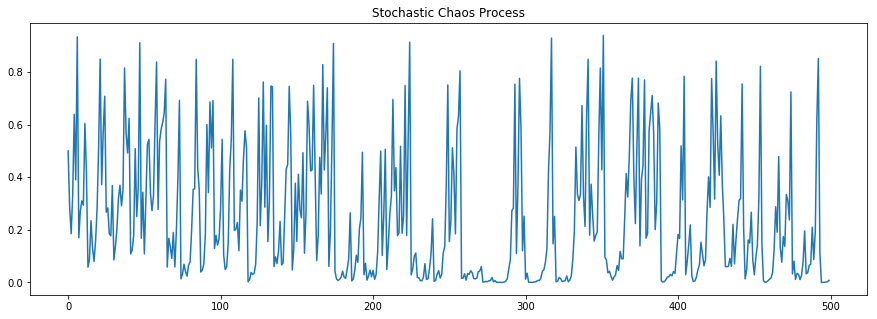

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(y)
plt.title('Stochastic Chaos Process')
plt.show()

In [6]:
lags = 4
cols = []
for lag in range(1,lags+1):
    col = 'lag_%d'% lag
    cols.append(col)
    df[col] = df['sc_model'].shift(lag)
df.head(5)

,sc_model,lag_1,lag_2,lag_3,lag_4
0,0.500000,NaN,NaN,NaN,NaN
1,0.286139,0.500000,NaN,NaN,NaN
2,0.185350,0.286139,0.500000,NaN,NaN
3,0.332984,0.185350,0.286139,0.500000,NaN
4,0.639192,0.332984,0.185350,0.286139,0.5


In [7]:
df = df.dropna(how='any')
df.head()

,sc_model,lag_1,lag_2,lag_3,lag_4
4,0.639192,0.332984,0.185350,0.286139,0.500000
5,0.390316,0.639192,0.332984,0.185350,0.286139
6,0.933568,0.390316,0.639192,0.332984,0.185350
7,0.169889,0.933568,0.390316,0.639192,0.332984
8,0.271297,0.169889,0.933568,0.390316,0.639192


In [8]:
Y = df['sc_model'].values
X = df[cols].values

test_Y = Y[-100:]
test_X = X[-100:]

train_Y = Y[:-100]
train_X = X[:-100]

## OLS Regression

In [9]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

/home/mehdi/Py36Env/py36env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
model = sm.OLS(train_Y, train_X)
results = model.fit()
#results.summary()

In [11]:
ols_results = pd.DataFrame(y, columns=['model'])
ols_results['in_sample'] = np.nan
ols_results['out_sample'] = np.nan
ols_in_sample = results.fittedvalues.flatten()
ols_out_sample = results.predict(test_X)

ols_results.loc[5:400, 'in_sample'] = results.fittedvalues.flatten()
ols_results.loc[400:, 'out_sample'] = results.predict(test_X)

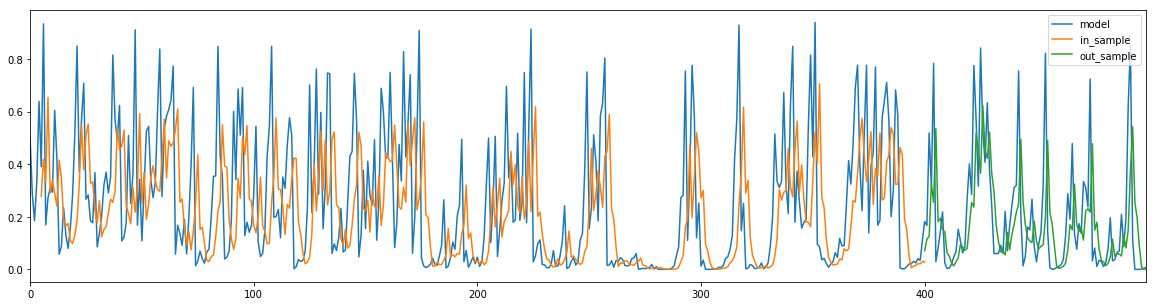

In [12]:
ols_results.plot(figsize=(20, 5));

In [13]:
# calculate root mean squared error and sucess ratio
success_ratio = lambda a, b: np.mean(np.sign(a)==np.sign(b))

ols_train_rmse = np.sqrt(mean_squared_error(train_Y, ols_in_sample))
ols_test_rmse = np.sqrt(mean_squared_error(test_Y, ols_out_sample))
sr = success_ratio(test_Y, ols_out_sample)
print('OLS in sample -- RMSE: %.2f , R2: %.2f' % (ols_train_rmse, r2_score(train_Y, ols_in_sample)))
print('OLS out of sample -- RMSE: %.2f, R2: %.2f, SR: %.2f' % (ols_test_rmse, r2_score(test_Y, ols_out_sample), sr))

OLS in sample -- RMSE: 0.22 , R2: 0.20
OLS out of sample -- RMSE: 0.21, R2: 0.11, SR: 1.00


## Deep Learning with Keras

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.advanced_activations import *
import keras.backend as Kb

Using Theano backend.


In [15]:
def success_ratio(y_true, y_pred):
    return Kb.mean(Kb.equal(Kb.sign(y_true), Kb.sign(y_pred)))

In [16]:
model = Sequential()
model.add(Dense(lags, input_dim=lags))
#model.add(Activation('tanh'))
model.add(LeakyReLU())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[success_ratio])
#print(model.summary())

In [17]:
history = model.fit(train_X, train_Y, 
                    validation_data=(test_X, test_Y),
                    epochs=1000, batch_size=100, verbose=2)

Train on 396 samples, validate on 100 samples
Epoch 1/1000
0s - loss: 0.0855 - success_ratio: 0.8586 - val_loss: 0.0647 - val_success_ratio: 0.8200
Epoch 2/1000
0s - loss: 0.0814 - success_ratio: 0.8965 - val_loss: 0.0626 - val_success_ratio: 0.8800
Epoch 3/1000
0s - loss: 0.0781 - success_ratio: 0.9116 - val_loss: 0.0607 - val_success_ratio: 0.8900
Epoch 4/1000
0s - loss: 0.0752 - success_ratio: 0.9268 - val_loss: 0.0592 - val_success_ratio: 0.9200
Epoch 5/1000
0s - loss: 0.0725 - success_ratio: 0.9318 - val_loss: 0.0579 - val_success_ratio: 0.9300
Epoch 6/1000
0s - loss: 0.0705 - success_ratio: 0.9470 - val_loss: 0.0569 - val_success_ratio: 0.9400
Epoch 7/1000
0s - loss: 0.0688 - success_ratio: 0.9520 - val_loss: 0.0561 - val_success_ratio: 0.9400
Epoch 8/1000
0s - loss: 0.0672 - success_ratio: 0.9571 - val_loss: 0.0554 - val_success_ratio: 0.9500
Epoch 9/1000
0s - loss: 0.0660 - success_ratio: 0.9621 - val_loss: 0.0550 - val_success_ratio: 0.9500
Epoch 10/1000
0s - loss: 0.0650 - su

0s - loss: 0.0484 - success_ratio: 1.0000 - val_loss: 0.0428 - val_success_ratio: 1.0000
Epoch 86/1000
0s - loss: 0.0483 - success_ratio: 1.0000 - val_loss: 0.0427 - val_success_ratio: 1.0000
Epoch 87/1000
0s - loss: 0.0483 - success_ratio: 1.0000 - val_loss: 0.0427 - val_success_ratio: 1.0000
Epoch 88/1000
0s - loss: 0.0482 - success_ratio: 1.0000 - val_loss: 0.0426 - val_success_ratio: 1.0000
Epoch 89/1000
0s - loss: 0.0481 - success_ratio: 1.0000 - val_loss: 0.0425 - val_success_ratio: 1.0000
Epoch 90/1000
0s - loss: 0.0481 - success_ratio: 1.0000 - val_loss: 0.0424 - val_success_ratio: 1.0000
Epoch 91/1000
0s - loss: 0.0481 - success_ratio: 1.0000 - val_loss: 0.0424 - val_success_ratio: 1.0000
Epoch 92/1000
0s - loss: 0.0480 - success_ratio: 1.0000 - val_loss: 0.0423 - val_success_ratio: 1.0000
Epoch 93/1000
0s - loss: 0.0480 - success_ratio: 1.0000 - val_loss: 0.0422 - val_success_ratio: 1.0000
Epoch 94/1000
0s - loss: 0.0479 - success_ratio: 1.0000 - val_loss: 0.0422 - val_succes

0s - loss: 0.0416 - success_ratio: 1.0000 - val_loss: 0.0363 - val_success_ratio: 1.0000
Epoch 244/1000
0s - loss: 0.0416 - success_ratio: 1.0000 - val_loss: 0.0363 - val_success_ratio: 1.0000
Epoch 245/1000
0s - loss: 0.0416 - success_ratio: 1.0000 - val_loss: 0.0362 - val_success_ratio: 1.0000
Epoch 246/1000
0s - loss: 0.0416 - success_ratio: 1.0000 - val_loss: 0.0362 - val_success_ratio: 1.0000
Epoch 247/1000
0s - loss: 0.0416 - success_ratio: 1.0000 - val_loss: 0.0363 - val_success_ratio: 1.0000
Epoch 248/1000
0s - loss: 0.0415 - success_ratio: 1.0000 - val_loss: 0.0364 - val_success_ratio: 1.0000
Epoch 249/1000
0s - loss: 0.0415 - success_ratio: 1.0000 - val_loss: 0.0363 - val_success_ratio: 1.0000
Epoch 250/1000
0s - loss: 0.0415 - success_ratio: 1.0000 - val_loss: 0.0363 - val_success_ratio: 1.0000
Epoch 251/1000
0s - loss: 0.0415 - success_ratio: 1.0000 - val_loss: 0.0362 - val_success_ratio: 1.0000
Epoch 252/1000
0s - loss: 0.0415 - success_ratio: 1.0000 - val_loss: 0.0362 - v

0s - loss: 0.0399 - success_ratio: 1.0000 - val_loss: 0.0351 - val_success_ratio: 1.0000
Epoch 339/1000
0s - loss: 0.0399 - success_ratio: 1.0000 - val_loss: 0.0350 - val_success_ratio: 1.0000
Epoch 340/1000
0s - loss: 0.0398 - success_ratio: 1.0000 - val_loss: 0.0349 - val_success_ratio: 1.0000
Epoch 341/1000
0s - loss: 0.0398 - success_ratio: 1.0000 - val_loss: 0.0350 - val_success_ratio: 1.0000
Epoch 342/1000
0s - loss: 0.0398 - success_ratio: 1.0000 - val_loss: 0.0350 - val_success_ratio: 1.0000
Epoch 343/1000
0s - loss: 0.0398 - success_ratio: 1.0000 - val_loss: 0.0350 - val_success_ratio: 1.0000
Epoch 344/1000
0s - loss: 0.0398 - success_ratio: 1.0000 - val_loss: 0.0349 - val_success_ratio: 1.0000
Epoch 345/1000
0s - loss: 0.0398 - success_ratio: 1.0000 - val_loss: 0.0350 - val_success_ratio: 1.0000
Epoch 346/1000
0s - loss: 0.0398 - success_ratio: 1.0000 - val_loss: 0.0349 - val_success_ratio: 1.0000
Epoch 347/1000
0s - loss: 0.0397 - success_ratio: 1.0000 - val_loss: 0.0349 - v

Epoch 432/1000
0s - loss: 0.0386 - success_ratio: 1.0000 - val_loss: 0.0341 - val_success_ratio: 1.0000
Epoch 433/1000
0s - loss: 0.0386 - success_ratio: 1.0000 - val_loss: 0.0340 - val_success_ratio: 1.0000
Epoch 434/1000
0s - loss: 0.0386 - success_ratio: 1.0000 - val_loss: 0.0340 - val_success_ratio: 1.0000
Epoch 435/1000
0s - loss: 0.0386 - success_ratio: 1.0000 - val_loss: 0.0340 - val_success_ratio: 1.0000
Epoch 436/1000
0s - loss: 0.0385 - success_ratio: 1.0000 - val_loss: 0.0340 - val_success_ratio: 1.0000
Epoch 437/1000
0s - loss: 0.0385 - success_ratio: 1.0000 - val_loss: 0.0340 - val_success_ratio: 1.0000
Epoch 438/1000
0s - loss: 0.0385 - success_ratio: 1.0000 - val_loss: 0.0340 - val_success_ratio: 1.0000
Epoch 439/1000
0s - loss: 0.0385 - success_ratio: 1.0000 - val_loss: 0.0339 - val_success_ratio: 1.0000
Epoch 440/1000
0s - loss: 0.0385 - success_ratio: 1.0000 - val_loss: 0.0339 - val_success_ratio: 1.0000
Epoch 441/1000
0s - loss: 0.0385 - success_ratio: 1.0000 - val_l

0s - loss: 0.0376 - success_ratio: 1.0000 - val_loss: 0.0333 - val_success_ratio: 1.0000
Epoch 517/1000
0s - loss: 0.0376 - success_ratio: 1.0000 - val_loss: 0.0333 - val_success_ratio: 1.0000
Epoch 518/1000
0s - loss: 0.0376 - success_ratio: 1.0000 - val_loss: 0.0333 - val_success_ratio: 1.0000
Epoch 519/1000
0s - loss: 0.0376 - success_ratio: 1.0000 - val_loss: 0.0332 - val_success_ratio: 1.0000
Epoch 520/1000
0s - loss: 0.0376 - success_ratio: 1.0000 - val_loss: 0.0333 - val_success_ratio: 1.0000
Epoch 521/1000
0s - loss: 0.0375 - success_ratio: 1.0000 - val_loss: 0.0333 - val_success_ratio: 1.0000
Epoch 522/1000
0s - loss: 0.0376 - success_ratio: 1.0000 - val_loss: 0.0330 - val_success_ratio: 1.0000
Epoch 523/1000
0s - loss: 0.0375 - success_ratio: 1.0000 - val_loss: 0.0331 - val_success_ratio: 1.0000
Epoch 524/1000
0s - loss: 0.0375 - success_ratio: 1.0000 - val_loss: 0.0331 - val_success_ratio: 1.0000
Epoch 525/1000
0s - loss: 0.0375 - success_ratio: 1.0000 - val_loss: 0.0332 - v

Epoch 604/1000
0s - loss: 0.0368 - success_ratio: 0.9975 - val_loss: 0.0327 - val_success_ratio: 1.0000
Epoch 605/1000
0s - loss: 0.0368 - success_ratio: 0.9975 - val_loss: 0.0326 - val_success_ratio: 1.0000
Epoch 606/1000
0s - loss: 0.0368 - success_ratio: 0.9975 - val_loss: 0.0325 - val_success_ratio: 1.0000
Epoch 607/1000
0s - loss: 0.0368 - success_ratio: 0.9975 - val_loss: 0.0326 - val_success_ratio: 1.0000
Epoch 608/1000
0s - loss: 0.0368 - success_ratio: 0.9975 - val_loss: 0.0327 - val_success_ratio: 1.0000
Epoch 609/1000
0s - loss: 0.0367 - success_ratio: 0.9975 - val_loss: 0.0326 - val_success_ratio: 1.0000
Epoch 610/1000
0s - loss: 0.0367 - success_ratio: 0.9975 - val_loss: 0.0325 - val_success_ratio: 1.0000
Epoch 611/1000
0s - loss: 0.0368 - success_ratio: 0.9975 - val_loss: 0.0323 - val_success_ratio: 1.0000
Epoch 612/1000
0s - loss: 0.0367 - success_ratio: 0.9975 - val_loss: 0.0324 - val_success_ratio: 1.0000
Epoch 613/1000
0s - loss: 0.0367 - success_ratio: 0.9975 - val_l

0s - loss: 0.0356 - success_ratio: 0.9899 - val_loss: 0.0317 - val_success_ratio: 0.9900
Epoch 766/1000
0s - loss: 0.0356 - success_ratio: 0.9899 - val_loss: 0.0316 - val_success_ratio: 0.9900
Epoch 767/1000
0s - loss: 0.0356 - success_ratio: 0.9899 - val_loss: 0.0317 - val_success_ratio: 0.9900
Epoch 768/1000
0s - loss: 0.0356 - success_ratio: 0.9899 - val_loss: 0.0316 - val_success_ratio: 0.9900
Epoch 769/1000
0s - loss: 0.0356 - success_ratio: 0.9899 - val_loss: 0.0315 - val_success_ratio: 0.9900
Epoch 770/1000
0s - loss: 0.0356 - success_ratio: 0.9899 - val_loss: 0.0316 - val_success_ratio: 0.9900
Epoch 771/1000
0s - loss: 0.0356 - success_ratio: 0.9899 - val_loss: 0.0317 - val_success_ratio: 0.9900
Epoch 772/1000
0s - loss: 0.0356 - success_ratio: 0.9899 - val_loss: 0.0318 - val_success_ratio: 1.0000
Epoch 773/1000
0s - loss: 0.0356 - success_ratio: 0.9899 - val_loss: 0.0317 - val_success_ratio: 0.9900
Epoch 774/1000
0s - loss: 0.0356 - success_ratio: 0.9899 - val_loss: 0.0315 - v

0s - loss: 0.0351 - success_ratio: 0.9899 - val_loss: 0.0312 - val_success_ratio: 0.9900
Epoch 856/1000
0s - loss: 0.0351 - success_ratio: 0.9899 - val_loss: 0.0312 - val_success_ratio: 0.9900
Epoch 857/1000
0s - loss: 0.0351 - success_ratio: 0.9899 - val_loss: 0.0311 - val_success_ratio: 0.9900
Epoch 858/1000
0s - loss: 0.0352 - success_ratio: 0.9899 - val_loss: 0.0312 - val_success_ratio: 0.9900
Epoch 859/1000
0s - loss: 0.0351 - success_ratio: 0.9874 - val_loss: 0.0310 - val_success_ratio: 0.9900
Epoch 860/1000
0s - loss: 0.0351 - success_ratio: 0.9848 - val_loss: 0.0309 - val_success_ratio: 0.9900
Epoch 861/1000
0s - loss: 0.0351 - success_ratio: 0.9874 - val_loss: 0.0311 - val_success_ratio: 0.9900
Epoch 862/1000
0s - loss: 0.0351 - success_ratio: 0.9874 - val_loss: 0.0312 - val_success_ratio: 0.9900
Epoch 863/1000
0s - loss: 0.0351 - success_ratio: 0.9899 - val_loss: 0.0311 - val_success_ratio: 0.9900
Epoch 864/1000
0s - loss: 0.0350 - success_ratio: 0.9874 - val_loss: 0.0312 - v

0s - loss: 0.0346 - success_ratio: 0.9874 - val_loss: 0.0309 - val_success_ratio: 0.9900
Epoch 948/1000
0s - loss: 0.0346 - success_ratio: 0.9874 - val_loss: 0.0308 - val_success_ratio: 0.9900
Epoch 949/1000
0s - loss: 0.0346 - success_ratio: 0.9874 - val_loss: 0.0307 - val_success_ratio: 0.9900
Epoch 950/1000
0s - loss: 0.0346 - success_ratio: 0.9874 - val_loss: 0.0308 - val_success_ratio: 0.9900
Epoch 951/1000
0s - loss: 0.0346 - success_ratio: 0.9874 - val_loss: 0.0306 - val_success_ratio: 0.9900
Epoch 952/1000
0s - loss: 0.0346 - success_ratio: 0.9848 - val_loss: 0.0306 - val_success_ratio: 0.9900
Epoch 953/1000
0s - loss: 0.0346 - success_ratio: 0.9874 - val_loss: 0.0307 - val_success_ratio: 0.9900
Epoch 954/1000
0s - loss: 0.0346 - success_ratio: 0.9874 - val_loss: 0.0308 - val_success_ratio: 0.9900
Epoch 955/1000
0s - loss: 0.0346 - success_ratio: 0.9874 - val_loss: 0.0307 - val_success_ratio: 0.9900
Epoch 956/1000
0s - loss: 0.0346 - success_ratio: 0.9848 - val_loss: 0.0305 - v

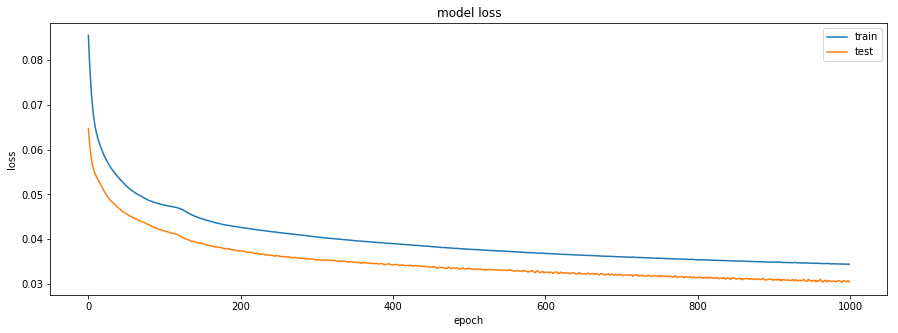

In [18]:
plt.figure(figsize=(15, 5)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

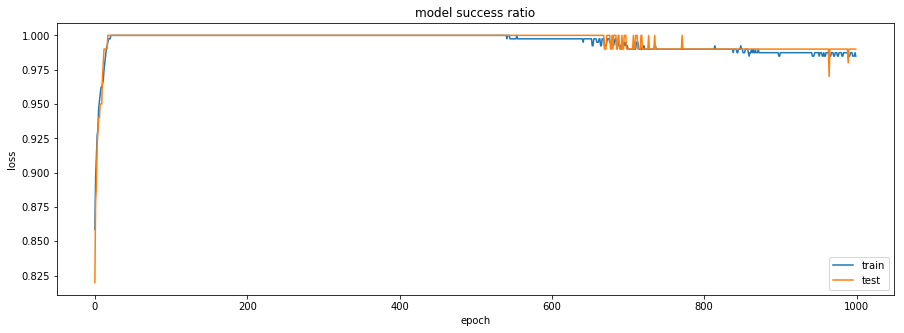

In [19]:
plt.figure(figsize=(15, 5)) 
plt.plot(history.history['success_ratio'])
plt.plot(history.history['val_success_ratio']) 
plt.title('model success ratio') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

In [20]:
# make predictions
keras_in_sample = model.predict(train_X).flatten()
keras_out_sample = model.predict(test_X).flatten()
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(train_Y, keras_in_sample))

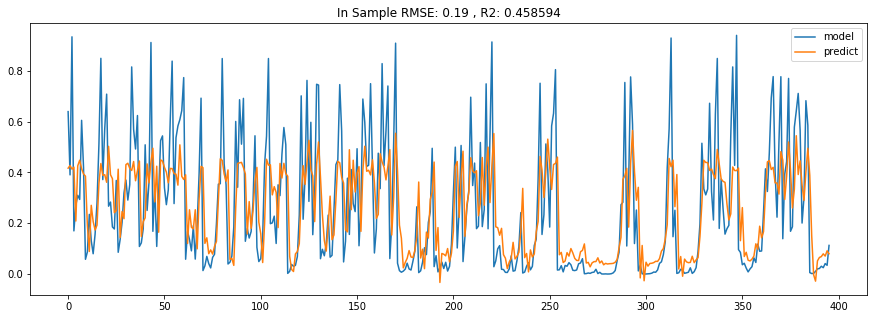

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(train_Y, label='model')
plt.plot(keras_in_sample, label='predict')
# calculate root mean squared error
plt.title('In Sample RMSE: %.2f , R2: %2f' % (np.sqrt(mean_squared_error(train_Y, keras_in_sample)), 
                                                  r2_score(train_Y, keras_in_sample)))
plt.legend(loc=0)
plt.show()

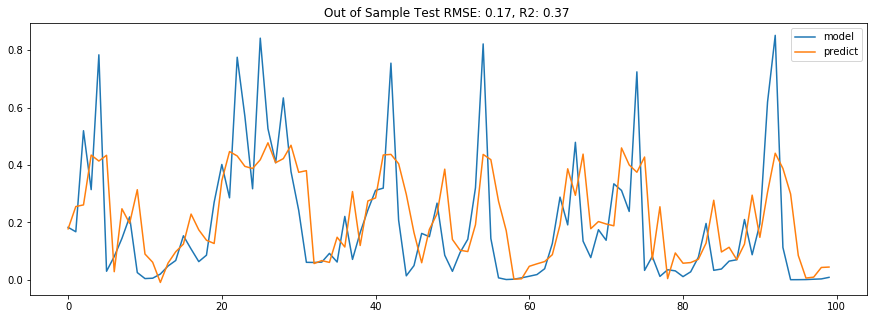

In [22]:
plt.figure(figsize=(15, 5))
plt.plot(test_Y, label='model')
plt.plot(keras_out_sample, label='predict')
# calculate root mean squared error
plt.title('Out of Sample Test RMSE: %.2f, R2: %.2f ' % (np.sqrt(mean_squared_error(test_Y, keras_out_sample)),
                                              r2_score(test_Y, keras_out_sample)))
plt.legend(loc=0)
plt.show()